In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
# matplotlib.rcParams["font.family"] = 'sans-serif'
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import math
import numpy as np
import itertools
from scipy.stats import bootstrap, beta
from joblib import Parallel, delayed
from scipy.special import beta as B

### Case 1: IID

Given the observed data $x_1, \dots, x_t$, we consider the following estimates.

MLE:

$$\hat p_s = \frac{1}{t} \sum_{r = 1}^t x_i, \ \forall s > t$$

MAP: 

$$\hat p_s = \frac{\alpha + \sum_{r = 1}^t x_i - 1}{\alpha + \beta + t - 2}, \ \forall s > t$$

MAP + Prospection:

Let $\hat p_t$ be the MAP estimate based on the original observations $x_1, \dots, x_t$. Let $\hat p_t^b$ be the bootstrap MAP estimate from the bootstrap sample $b$. We consider $B$ such bootstrap samples. Define, 
$$ \Delta = | \hat p_t - \text{mean}(\hat p_t^1, \dots, \hat p_t^B) |. $$
The estimates for future time steps $s > t$ is then given by,
$$ \hat p_s = \hat p_t + \dot{\Delta} (s - t), \ \forall s > t $$

In [668]:
class Learners:
    def __init__(self, data=None, t=None, T=None, mode=0.5, conc=10) -> None:
        self.t = t
        self.T = T
        self.alpha, self.beta = self.compute_alpha_beta(mode, conc)
        self.data = data
        self.thresh = 0.5
        self.mode = mode
        self.delta_dot = 0
        if data is not None:
            self.p_mle = self.compute_mle(data)
            self.p_map = self.compute_map(data)
            self.pred_post_dist = self.compute_pred_post_dist(data)
            self.p_prol = self.compute_prospective_map(data)

    def compute_alpha_beta(self, mode, conc):
        alpha = mode * (conc - 2) + 1
        beta = (1 - mode) * (conc - 2) + 1
        return alpha, beta
        
    def compute_mle(self, data):
        return np.mean(data)

    def compute_map(self, data):
        nom = self.alpha + np.sum(data) - 1
        denom = self.alpha + self.beta + self.t - 2
        return nom/denom
    
    def compute_pred_post_dist(self, data):
        nom = B(self.alpha + np.sum(data) + 1, self.beta + self.t - np.sum(data) - 1)
        denom = B(self.alpha + np.sum(data) - 1, self.beta + self.t - np.sum(data) - 1)
        return nom/denom
    
    def compute_delta_dot(self, p, t):
        alpha_1 = self.alpha - 1
        beta_1 = self.beta - 1
        t_1 = t - 1
        r1 = (alpha_1 + t*p)/(alpha_1 + beta_1 + t)
        r2 = (alpha_1 + t_1*p)/(alpha_1 + beta_1 + t_1)
        return r1 - r2
    
    def compute_prospective_map(self, data):
        res = bootstrap((data, ), self.compute_map, vectorized=False, n_resamples=500)
        p = np.mean(res.bootstrap_distribution) # 'estimate' for true p using bootstraps

        delta_dots = [self.compute_delta_dot(p, r) for r in np.arange(self.t, self.T, 1)]
        self.delta_dot = self.compute_delta_dot(p, self.t)
        int_delta_dots = np.array([np.sum(delta_dots[:r]) for r in range(len(delta_dots))])
        p_hat_s = p + int_delta_dots * p * (1-p)

        return p_hat_s
    
def sample_from_process(p, size):
    return np.random.binomial(n=1, p=p*np.ones(size))

def loss(truth, pred):
    return (truth - pred)**2

In [669]:
# run a replicate
def run_replicate(t, T, p, prior_mode, prior_conc, reps):
    # sample a t-length sequence
    past_data = sample_from_process(p, (t,))  

    L = Learners(past_data, t, T, prior_mode, prior_conc)  

    # sample replicate sequences of the future data
    size = (T-t,)
    p_true = p * np.ones(size)

    return loss(p_true, L.p_mle), loss(p_true, L.p_map), loss(p_true, L.p_prol)

In [670]:
# params
p = 0.8
T = 20
t_list = np.arange(2, T, 1)
prior_mode = 0.3
prior_conc = 15
reps = 1000

In [671]:
sqd_errs_at_s = []
avg_sqd_err = []
for t in t_list:
    tmp = Parallel(n_jobs=-1)(delayed(run_replicate)(t, T, p, prior_mode, prior_conc, reps) for _ in range(reps))
    tmp = np.array(tmp)
    sqd_errs_at_s.append(np.mean(tmp, axis=0))
    avg_sqd_err.append(np.mean(tmp, axis=(0, 2)))
avg_sqd_err = np.array(avg_sqd_err)

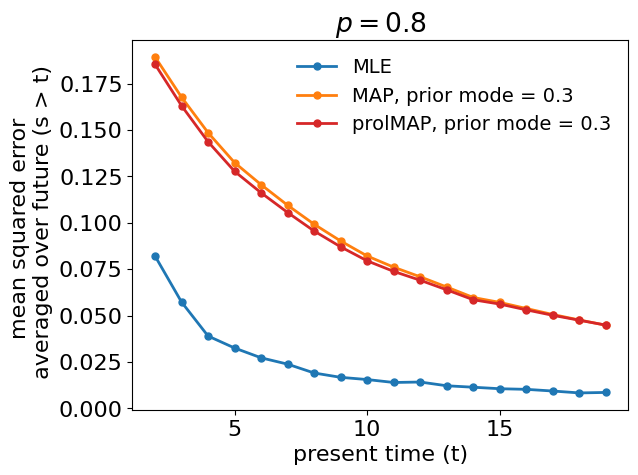

In [672]:
fig, ax = plt.subplots()
colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[1], sns.color_palette("tab10")[3]]

labels = ['MLE', f'MAP, prior mode = {prior_mode}', f'prolMAP, prior mode = {prior_mode}']
for i, label in enumerate(labels):
    ax.plot(t_list, avg_sqd_err[:, i], 
            label=f'{label}', 
            color=colors[i], marker='o', ms=5, lw=2)

ax.set_xlabel('present time (t)')
ax.set_ylabel('mean squared error \n averaged over future (s > t)')
ax.set_title(fr"$p = {p}$")
ax.legend(frameon=False, fontsize=14)
plt.show()

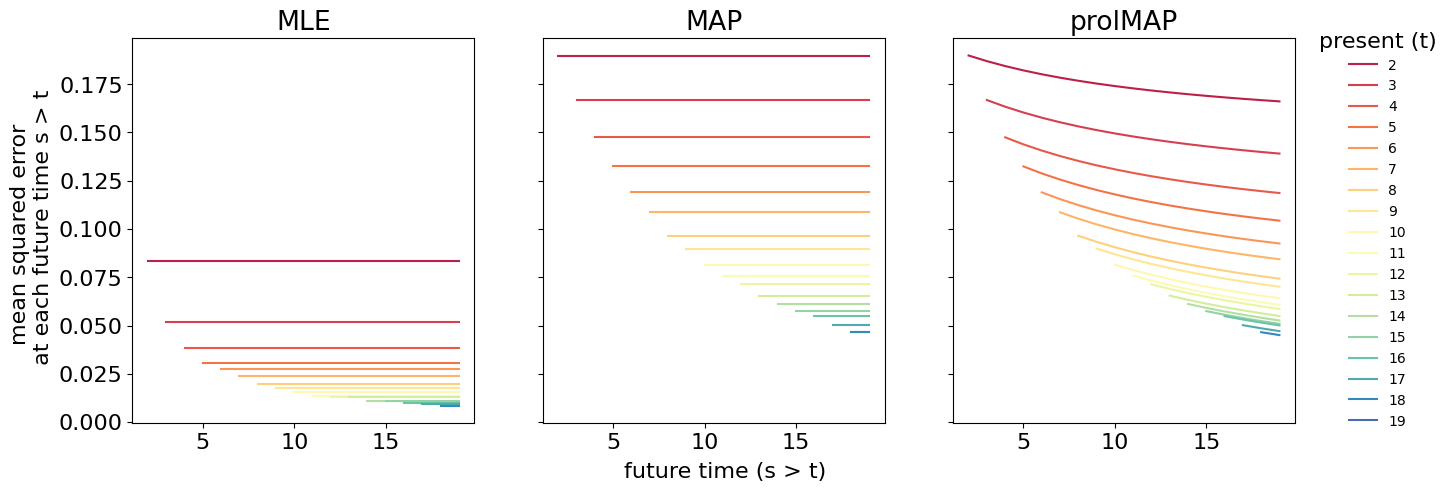

In [661]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey='row')
colors = sns.color_palette("Spectral", n_colors=len(sqd_errs_at_s))
for i, t in enumerate(t_list):
    ax[0].plot(t_list[i:], sqd_errs_at_s[i][0, :], color=colors[i], label=f'{t}')
    ax[0].set_title('MLE')
    ax[1].plot(t_list[i:], sqd_errs_at_s[i][1, :], color=colors[i], label=f'{t}')
    ax[1].set_title('MAP')
    ax[2].plot(t_list[i:], sqd_errs_at_s[i][2, :], color=colors[i], label=f'{t}')
    ax[2].set_title('prolMAP')
ax[0].set_ylabel('mean squared error \n at each future time s > t')
ax[2].legend(fontsize=10, loc='best', bbox_to_anchor=(0.95, 0.55, 0.5, 0.5), title='present (t)', frameon=False)
fig.text(0.52, 0.00, 'future time (s > t)', ha='center')
plt.show()

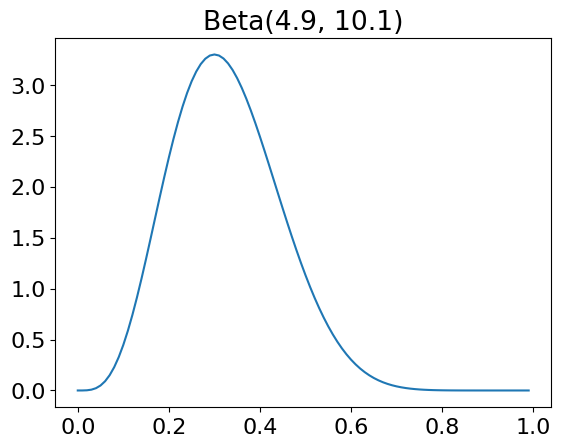

In [652]:
L = Learners(mode=prior_mode, conc=prior_conc)  
plt.plot(np.arange(0, 1, 0.01), beta(L.alpha, L.beta).pdf(np.arange(0, 1, 0.01)))
plt.title(f'Beta({L.alpha}, {L.beta})')
plt.show()

In [674]:
# params
p = 0.8
T = 50
t_list = np.arange(2, T, 2)
prior_mode = 0.3
prior_conc = 15
reps = 1000

In [675]:
def loop(p, t, T, prior_mode, prior_conc):
    past_data = sample_from_process(p, (t,))  
    L = Learners(past_data, t, T, prior_mode, prior_conc)
    return L.p_mle, L.p_map, L.delta_dot

stuff = []
std = []
for t in t_list:
    tmp = Parallel(n_jobs=-1)(delayed(loop)(p, t, T, prior_mode, prior_conc) for _ in range(reps))
    stuff.append(np.mean(tmp, axis=0))
    std.append(np.std(tmp, axis=0))
stuff = np.array(stuff)
std = np.array(std)

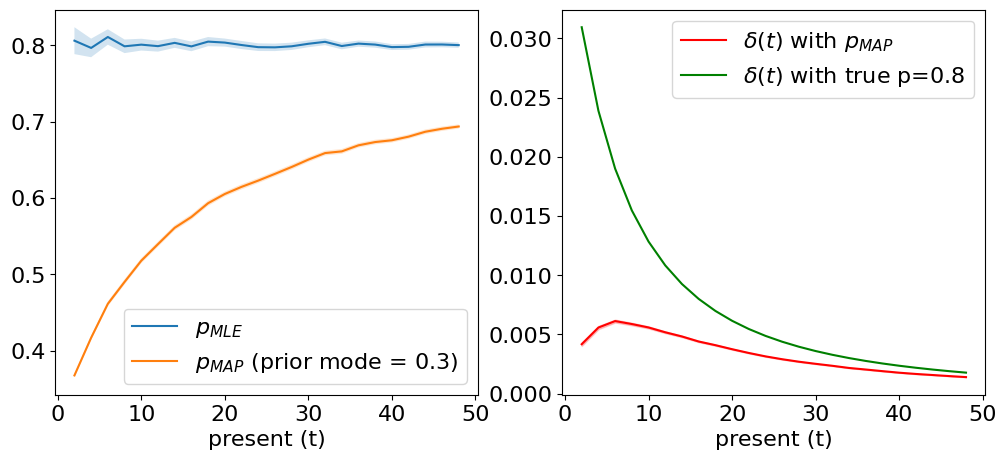

In [676]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
labels = [r'$p_{MLE}$', r'$p_{MAP}$' + f' (prior mode = {prior_mode})']
for i, label in enumerate(labels):
    ax[0].plot(t_list, stuff[:, i], label=label)
    ci = std[:, i] / np.sqrt(reps) * 1.96
    ax[0].fill_between(t_list, stuff[:, i]-ci, stuff[:, i]+ci, alpha=0.2)
ax[0].legend()
ax[0].set_xlabel('present (t)')

ax[1].plot(t_list, stuff[:, 2], label=r'$\delta(t)$ with $p_{MAP}$', c='r')
ci = std[:, 2] / np.sqrt(reps) * 1.96
ax[1].fill_between(t_list, stuff[:, 2]-ci, stuff[:, 2]+ci, alpha=0.2, color='r')
ax[1].set_xlabel('present (t)')

past_data = sample_from_process(p, (t,))  
L = Learners(past_data, t, T, prior_mode, prior_conc)
delta_dot = [L.compute_delta_dot(p, t) for t in t_list]
ax[1].plot(t_list, delta_dot, label=r'$\delta(t)$ with true p=0.8', c='g')
ax[1].legend()
plt.show()

### Case 2: Independent

Given the observed data $x_1, \dots, x_t$, we consider the following estimates.

L1:

$$\hat p_s = \frac{1}{t} \left( \sum_{\text{odd} \ r}^t x_r + \sum_{\text{even} \ r}^t x_r \right)$$
$$
\hat h_s = 
\begin{cases}
    \text{Threshold}(\hat p_s), & s \ \text{odd} \\
    \text{Threshold}(\hat 1-p_s), & s \ \text{even} \\
\end{cases}
$$

L2: 

$$\hat p_s = \frac{1}{t} \sum_{\text{odd} \ r}^t x_r$$
$$\hat q_s = \frac{1}{t} \sum_{\text{even} \ r}^t x_r$$
$$
\hat h_s = 
\begin{cases}
    \text{Threshold}(\hat p_s), & s \ \text{odd} \\
    \text{Threshold}(\hat q_s), & s \ \text{even} \\
\end{cases}
$$

Bigram Model:

Based on the observations $x_1, \dots, x_t$, we estimate the $2 \times 2$ state transition matrix $P$ where $P_{ij} = prob(x_t = i \mid x_{t-1} = j)$. During inference, we first compute the state probability distirbution at $s > t$ by
$$ p_s = p_t P^{s-t} $$ 
where $p_t = [0, 1]$ is $x_t = 1$ and $p_t = [1, 0]$ otherwise. The predicted outcome at $s$ is given by,
$$ h_s = \text{threshold}(p_s) $$


In [42]:
class Learners:
    def __init__(self, data=None, t=None, T=None) -> None:
        self.t = t
        self.T = T
        self.data = data
        
        # case 1:
        self.phat1 = self.compute_phat()

        # case 2:
        self.phat2, self.qhat2 = self.compute_pqhat()

        # case 3: 
        self.T = self.compute_transition_matrix()

    def compute_phat(self):
        data = np.copy(self.data)
        tmp = data[1::2]
        data[1::2] = 1-tmp
        return np.mean(data)
    
    def compute_pqhat(self):
        data = np.copy(self.data)
        tmp1 = data[0::2]
        tmp2 = data[1::2]
        p_hat = np.mean(tmp1)
        q_hat = 0.5 if len(tmp2)==0 else np.mean(tmp2)
        return p_hat, q_hat
    
    def compute_alpha_beta(self, mode, conc):
        alpha = mode * (conc - 2) + 1
        beta = (1 - mode) * (conc - 2) + 1
        return alpha, beta
    
    def compute_map(self, count, total,alpha, beta):
        nom = alpha + count - 1
        denom = alpha + beta + total - 2
        return nom/denom
    
    def compute_transition_matrix(self, bayesian=True):
        data = np.copy(self.data)
        T = {0: {0: 0, 1: 0}, 
             1: {0: 0, 1: 0}}
        for i in range(len(data)-1):
            u, v = data[i], data[i+1]
            T[u][v] += 1
        if bayesian:
            prior = lambda mode : self.compute_alpha_beta(mode, 8)
            for u, i in enumerate(T):
                if i == 0:
                    params = [prior(0.4), prior(0.6)]
                else:
                    params = [prior(0.6), prior(0.4)]
                total = sum(T[u].values())
                T[u] = dict([(v, self.compute_map(T[u][v], total, param[0], param[1])) for v, param in zip(T[u], params)])
        else:
            for u in T:
                T[u] = dict([(v, T[u][v]+1) for v in T[u]])
                total = sum(T[u].values())
                T[u] = dict([(v, T[u][v]/total) for v in T[u]])
        return T

    def hypothesis1(self, start, size):
        h = np.random.uniform(low=0, high=1, size=size)
        out = int(self.phat1 > 0.5)
        if start % 2:
            if self.phat1 != 0.5: h[:, 0::2], h[:, 1::2] = out, 1-out
        else:
            if self.phat1 != 0.5: h[:, 0::2], h[:, 1::2] = 1-out, out
        return h
    
    def hypothesis2(self, start, size):
        h = np.random.uniform(low=0, high=1, size=size)
        out_p = int(self.phat2 > 0.5)
        out_q = int(self.qhat2 > 0.5)
        if start % 2:
            if self.phat2 != 0.5: h[:, 0::2] = out_p 
            if self.qhat2 != 0.5: h[:, 1::2] = out_q
        else:
            if self.qhat2 != 0.5: h[:, 0::2] = out_q
            if self.phat2 != 0.5: h[:, 1::2] = out_p
        return h
    
    def hypothesis3(self, start, size):
        T = np.array([list(self.T[i].values()) for i in self.T])
        p_t = np.zeros((2, ))
        p_t[self.data[-1]] = 1
        h = np.random.uniform(low=0, high=1, size=size)
        p_s = p_t @ T
        for s in range(size[-1]):
            if p_s[1] != 0.5: h[:, s] = int(p_s[1] > 0.5)
            p_s = p_s @ T
        return h

    def hypothesis4(self, start, size):
        def next_outcome(prev_outcome):
            return max(self.T[prev_outcome], key=self.T[prev_outcome].get)
        h = np.ones(size)
        outcomes = []
        prev = self.data[-1]
        for _ in range(size[-1]):
            tmp = next_outcome(prev)
            outcomes.append(tmp)
            prev = tmp
        return h * outcomes   

def sample_from_process(p, q, start, size=None):
    order = [p, q] if start % 2 else [q, p]
    t = size[-1]
    p_list = order * (t // 2)
    if t % 2:
        p_list.append(order[0])
    return np.random.binomial(n=1, p=np.ones(size) * p_list)

def loss(truth, pred):
    return (truth - pred)**2

In [43]:
# run a replicate
def run_replicate(t, T, p, q, reps):
    # sample a t-length sequence
    past_data = sample_from_process(p, q, start=1, size=(t,))

    L = Learners(past_data, t, T)

    # sample replicate sequences of the future data
    size = (reps, T-t)
    future_data = sample_from_process(p, q, start=t+1, size=size)

    # evaluate the hypothesis on each of the replicate sequences and compute average loss per replicate
    average_losses_1 = np.mean(loss(future_data, L.hypothesis1(t+1, size)), axis=-1)
    average_losses_2 = np.mean(loss(future_data, L.hypothesis2(t+1, size)), axis=-1)
    average_losses_3 = np.mean(loss(future_data, L.hypothesis3(t+1, size)), axis=-1)
    # average_losses_4 = np.mean(loss(future_data, L.hypothesis4(t+1, size)), axis=-1)
    
    # compute the the average risk conditioned on the past data
    return np.mean(average_losses_1), np.mean(average_losses_2), np.mean(average_losses_3), # np.mean(average_losses_4)

In [44]:
# params
p = 0.9
q = 1-p
T = 20
t_list = np.arange(1, T, 1)
reps = 1000

In [45]:
expected_risks = []
std = []
for t in t_list:
    tmp = Parallel(n_jobs=-1)(delayed(run_replicate)(t, T, p, q, reps) for _ in range(reps))
    # compute the expected risk
    expected_risks.append(np.mean(tmp, axis=0))
    std.append(np.std(tmp, axis=0))

expected_risks = np.array(expected_risks)
std = np.array(std)
bayes_risk = (1-p)*np.ones((len(t_list),))

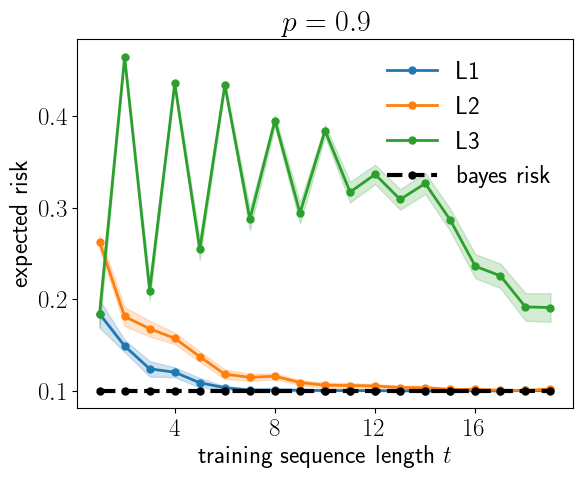

In [46]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab10")

labels = ['L1', 'L2', 'L3']
for i, label in enumerate(labels):
    ax.plot(t_list, expected_risks[:, i], 
            label=f'{label}', 
            color=colors[i], marker='o', ms=5, lw=2)
    ci = np.array(std[:, i]) * 1.96 / np.sqrt(reps)
    ax.fill_between(t_list, expected_risks[:, i]-ci, expected_risks[:, i]+ci, color=colors[i], alpha=0.2)

ax.plot(t_list, bayes_risk, lw=3, marker='o', ls='dashed', ms=5, color='k', label='bayes risk')

ax.set_xlabel(r'training sequence length $t$')
ax.set_ylabel('expected risk')
ax.set_title(fr"$p = {p}$")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
plt.show()

In [47]:
# save
fig.savefig("figures/case2.pdf", bbox_inches='tight')

In [366]:
def test_run(t, T, p, q, reps):
    past_data = sample_from_process(p, q, start=1, size=(t,))
    L = Learners(past_data, t, T)  
    T = np.array([list(L.T[i].values()) for i in L.T])
    return T.ravel()

In [367]:
probs = []
for t in t_list:
    tmp = Parallel(n_jobs=-1)(delayed(test_run)(t, T, p, q, reps) for _ in range(reps))
    probs.append(np.mean(tmp, axis=0))

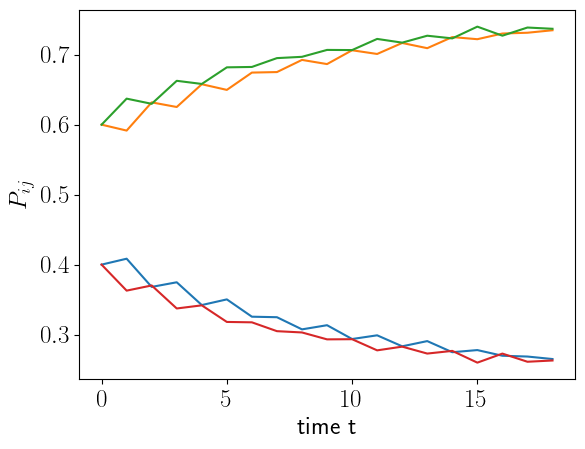

In [368]:
plt.plot(probs)
plt.xlabel('time t')
plt.ylabel(r'$P_{ij}$')
plt.show()

In [201]:
def hypothesis3(T, start, size):
    p_t = np.zeros((2, ))
    p_t[start] = 1
    h = np.random.uniform(low=0, high=1, size=size)
    p_s = p_t @ T
    for s in range(size[-1]):
        if p_s[1] != 0.5: h[:, s] = int(p_s[1] > 0.5)
        p_s = p_s @ T
    return h          

In [211]:
T = np.array([[0.2, 0.8], 
             [0.8, 0.2]])
hypothesis3(T, start = 1, size=(1, 100))

array([[0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 1.        , 0.        , 1.        , 0.23740406,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.  

#### Sub-case 4: Bigram modeling

In [351]:
def train(data):
    # create bigram model
    bigrams = {0: {0: 0, 1: 0}, 
               1: {0: 0, 1: 0}}
    for i in range(len(data)-1):
        u, v = data[i], data[i+1]
        bigrams[u][v] += 1
    for u in bigrams:
        bigrams[u] = dict([(v, bigrams[u][v]+1) for v in bigrams[u]])
        total = sum(bigrams[u].values())
        bigrams[u] = dict([(v, bigrams[u][v]/total) for v in bigrams[u]])
    return bigrams

def predict(bigrams, data, size): 
    def next_outcome(outcome):
        if list(bigrams[outcome].values()) == [0.5, 0.5]:
            return np.random.binomial(n=1, p=0.5)
        else:
            return max(bigrams[outcome], key=bigrams[outcome].get)
    preds = []
    for _ in range(size[0]):
        prev_outcome = data[-1]
        tmp = []
        for _ in range(size[-1]):
            outcome = next_outcome(prev_outcome)
            tmp.append(outcome)
            prev_outcome = outcome
        preds.append(tmp)
    return np.array(preds)

In [352]:
p = 0.9
q = 1-p
T = 20
t_list = np.arange(1, T, 1)
reps = 500
expected_future_risks_4 = []
std_4 = []
probs = []
for t in t_list:
    tmp = []
    tmp1 = []
    # randomly sample a training set
    for _ in range(reps):
        # sample a t-length sequence
        past_data = sample_from_process(p, q, start=1, size=(t,))
        bigrams = train(past_data)
        tmp1.append([bigrams[0][0], bigrams[0][1], bigrams[1][0], bigrams[1][1]])

        # sample future data
        future_data = sample_from_process(p, q, start=t+1, size=(reps, T-t))

        # evaluate the hypothesis on each of the 500 replicate sequences
        preds = predict(bigrams, past_data, size=(reps, T-t))
        cumulative_losses = np.mean((future_data - preds)**2, axis=-1)

        # compute the integrated risk divided by future duration
        future_risk = np.mean(cumulative_losses)
        tmp.append(future_risk)
    
    # compute the expected integrated risk by averaging out the randomness of training data 
    expected_future_risks_4.append(np.mean(tmp))
    std_4.append(np.std(tmp))

    probs.append(np.mean(tmp1, axis=0))

bayes_risk = (1-p)*np.ones((len(t_list),))

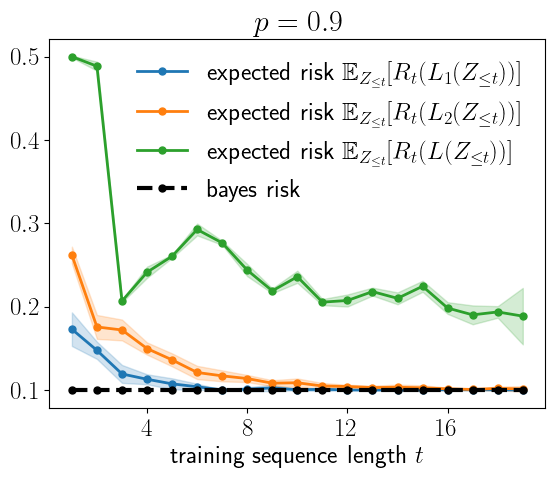

In [353]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab10")

color = colors[0]
ax.plot(t_list, expected_future_risks_1, 
         label=r'expected risk $\mathbb{E}_{Z_{\leq t}}[R_t(L_1(Z_{\leq t}))]$', 
         color=color, marker='o', ms=5, lw=2)
ci = np.array(std_1) * 1.96 / np.sqrt(reps)
ax.fill_between(t_list, expected_future_risks_1-ci, expected_future_risks_1+ci, color=color, alpha=0.2)

color = colors[1]
ax.plot(t_list, expected_future_risks_2, 
         label=r'expected risk $\mathbb{E}_{Z_{\leq t}}[R_t(L_2(Z_{\leq t}))]$', 
         color=color, marker='o', ms=5, lw=2)
ci = np.array(std_2) * 1.96 / np.sqrt(reps)
ax.fill_between(t_list, expected_future_risks_2-ci, expected_future_risks_2+ci, color=color, alpha=0.2)

color = colors[2]
ax.plot(t_list, expected_future_risks_4, 
         label=r'expected risk $\mathbb{E}_{Z_{\leq t}}[R_t(L(Z_{\leq t}))]$', 
         color=color, marker='o', ms=5, lw=2)
ci = np.array(std_3) * 1.96 / np.sqrt(reps)
ax.fill_between(t_list, expected_future_risks_4-ci, expected_future_risks_4+ci, color=color, alpha=0.2)

ax.plot(t_list, bayes_risk, lw=3, marker='o', ls='dashed', ms=5, color='k', label='bayes risk')

ax.set_xlabel(r'training sequence length $t$')
ax.set_title(fr"$p = {p}$")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
plt.show()

In [ ]:
# save
fig.savefig("figures/case2.pdf", bbox_inches='tight')

In [ ]:
p = 0.9
q = 1-p
T = 20
t_list = np.arange(1, T, 1)
reps = 500
expected_future_risks_4 = []
std_4 = []
probs = []
for t in t_list:
    tmp = []
    tmp1 = []
    # randomly sample a training set
    for _ in range(reps):
        # sample a t-length sequence
        past_data = sample_from_process(p, q, start=1, size=(t,))
        bigrams = train(past_data)
        tmp1.append([bigrams[0][0], bigrams[0][1], bigrams[1][0], bigrams[1][1]])

        # sample future data
        future_data = sample_from_process(p, q, start=t+1, size=(reps, T-t))

        # evaluate the hypothesis on each of the 500 replicate sequences
        preds = predict(bigrams, past_data, size=(reps, T-t))
        cumulative_losses = np.mean((future_data - preds)**2, axis=-1)

        # compute the integrated risk divided by future duration
        future_risk = np.mean(cumulative_losses)
        tmp.append(future_risk)
    
    # compute the expected integrated risk by averaging out the randomness of training data 
    expected_future_risks_4.append(np.mean(tmp))
    std_4.append(np.std(tmp))

    probs.append(np.mean(tmp1, axis=0))

bayes_risk = (1-p)*np.ones((len(t_list),))

In [450]:
class ListNode(object):
    def __init__(self, val=0, next=None):
        self.val = val
        self.next = next

### Case 3: Dependent

In [60]:
def hypothesis():
    return 1

p = 0.8
T = 10

# list all possible outcomes of the process
outcomes = np.array(list(map(list, itertools.product([0, 1], repeat=T)))).astype('float')

# compute the probability of each outcome using the product measure (due to iid assumption)
probs = np.copy(outcomes)
probs[probs == 1] = p
probs[probs == 0] = 1-p
prob_weight = np.prod(probs, axis=-1)

t_list = np.arange(1, T+1, 1)
future_risk_beyond_t = []
cumulative_losses = []

# loop over increasing values of t
for t in range(1, len(t_list), 1):
    # get the cumulative loss for each outcome
    cumulative_loss = np.sum((outcomes[:, t:].astype('int') != hypothesis()), axis=-1)
    cumulative_losses.append(cumulative_loss)
    
    # take the weighted average of the cumulative loss over all the outcomes (weight is the probabilities we computed above)
    expected_cumulative_loss = np.average(cumulative_loss, weights=prob_weight)
    future_risk_beyond_t.append(expected_cumulative_loss)

cumulative_losses = np.array(cumulative_losses)

Text(0.5, 1.0, 'p = 0.8')

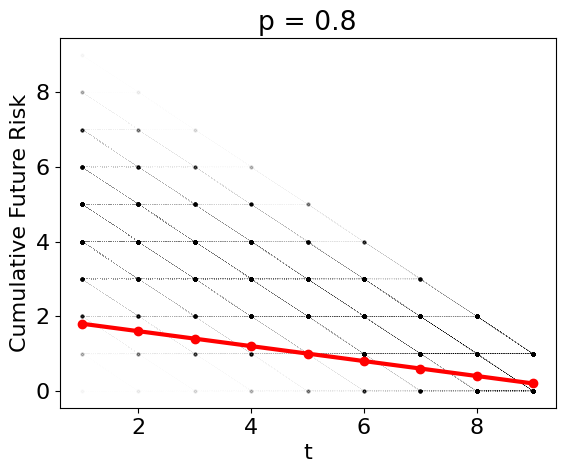

In [62]:
plt.plot(np.arange(1, T, 1), cumulative_losses, ls='dotted', marker='o', alpha=0.01, color='k', lw=0.5, ms=2)
plt.plot(np.arange(1, T, 1), future_risk_beyond_t, color='r', lw=3, marker='o')
plt.xlabel('t')
plt.ylabel(r'Cumulative Future Risk') # + '\n' + r'$R_t(h_{\geq t})$')
plt.title(f"p = {p}")

In [80]:
def hypothesis(p_hat):
    return (p_hat > 0.5).astype('int')

p = 0.8
T = 20 # length of the process being considered

# list all possible outcomes of the process
outcomes = np.array(list(map(list, itertools.product([0, 1], repeat=T)))).astype('float')

# compute the probability of each outcome using the product measure (due to iid assumption)
probs = np.copy(outcomes)
probs[probs == 1] = p
probs[probs == 0] = 1-p
prob_weight = np.prod(probs, axis=-1)

t_list = np.arange(1, T+1, 1)
future_risk_beyond_t = []

# loop over increasing values of t
for t in range(1, len(t_list), 1):

    # get the past (training) data at each outcome
    past_outcomes = outcomes[:, :t]

    # get the future (evaluation) data at each outcome
    future_outcomes = outcomes[:, t:]

    # compute the p_hat at each outcome based on past data
    p_hat = np.mean(past_outcomes, axis=-1)

    # get the hypothesis for each outcome
    h = np.repeat(hypothesis(p_hat).reshape(-1, 1), len(t_list)-t, axis=-1)

    # get the cumulative loss for each outcome
    cumulative_loss = np.mean((future_outcomes.astype('int') != h), axis=-1)

    # take the weighted average of the cumulative loss over all the outcomes (weight is the probabilities we computed above)
    expected_cumulative_loss = np.average(cumulative_loss, weights=prob_weight)
    future_risk_beyond_t.append(expected_cumulative_loss)

Text(0.5, 1.0, 'p = 0.8')

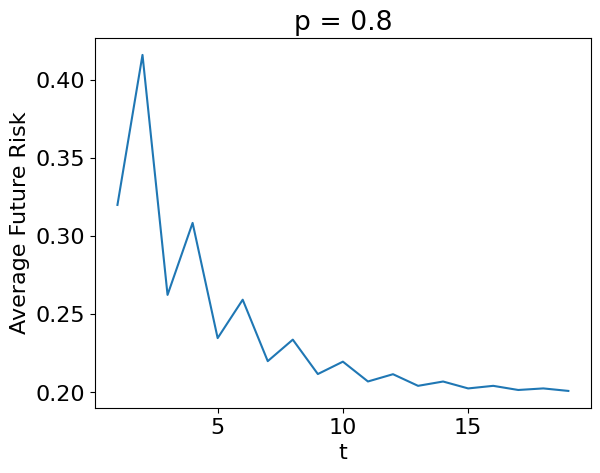

In [81]:
plt.plot(np.arange(1, T, 1), future_risk_beyond_t)
plt.xlabel('t')
plt.ylabel(r'Average Future Risk')
plt.title(f"p = {p}")

In [27]:
def get_p_hat(seq, alpha=2, beta=2):
    return np.divide(alpha + np.sum(seq) - 1, alpha + beta + len(seq) - 2)

def hypothesis(p_hat, size):
    if p_hat > 0.5:
        return 1
    elif p_hat < 0.5:
        return 0
    else:
        return np.random.uniform(low=0, high=1, size=size)
    
p = 0.8
T = 10
t_list = np.arange(1, T+1, 1)

conditional_risks_for_several_outcomes = []
outcomes = []
for _ in range(5):
    # sample an outcome (sequence) from the process
    outcome_from_the_process = np.random.binomial(n=1, p=p*np.ones(T))
    outcomes.append(outcome_from_the_process)

    conditional_average_future_risk = []
    for t in t_list:
        if t == T:
            break
        # compute p_hat based on the first t samples of the sequence
        p_hat = get_p_hat(outcome_from_the_process[:t])

        # sample replicates of the future sequence of length T-t (future distribution doesn't depend on the past, so no effect from the past data here)
        size = (1000, T-t)
        future_data = np.random.binomial(n=1, p=p*np.ones(size))

        # compute the average future loss on each of the replicate future sequences
        average_future_loss = np.sum((future_data - hypothesis(p_hat, size))**2, axis=-1)

        # compute the average future risk
        average_future_risk = np.mean(average_future_loss)

        conditional_average_future_risk.append(average_future_risk)
    conditional_risks_for_several_outcomes.append(conditional_average_future_risk)
    
conditional_risks_for_several_outcomes = np.array(conditional_risks_for_several_outcomes).T

bayes_cumulative_error = []
for t in t_list:
    if t == T:
        break
    bayes_cumulative_error.append(np.sum(0.2 * np.ones((T-t,))))

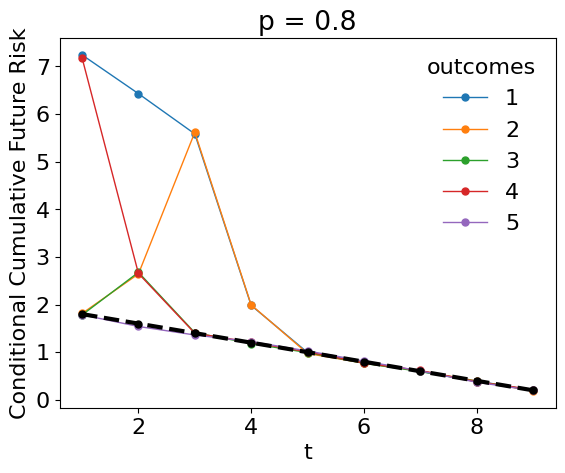

In [33]:
plt.plot(t_list[:-1], conditional_risks_for_several_outcomes, lw=1, marker='o', ms=5)
plt.plot(t_list[:-1], bayes_cumulative_error, lw=3, marker='o', ls='dashed', ms=5, color='k', label='Bayes Error')
plt.xlabel('t')
plt.ylabel(r'Conditional Cumulative Future Risk')
plt.title(f"p = {p}")
plt.legend(np.arange(1, 6, 1), title='outcomes', frameon=False)